# notebook n04: Validation of Freezing

Jose Oliveira da Cruz, PhD  | LeDoux Lab  
jose.cruz@nyu.edu  

<img src="LedouxLab_logo.jpg" style="width: 300.464px; height: 100px; margin: 0px;">   


This notebooks takes the .csv output from nb03 and computes some validation statistics for the freezing algorithm.

### Import dependencies

In [53]:
# Standart Library
import sys
import os

# Data Analysis
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
import pingouin as pg
from scipy import stats
import sklearn

<a id='step_1'><a/>
# 1) Load the data: `_merged_summary_stats.csv`

In [54]:
#where is the file
dir_path = r'D:\GoogleDrive\work\postdoc_nyu\scientific_projects\individual_differences\data\processed\EXP004\individual_summary_stats'
file_path = r'jc_exp004_20200110_tes01_r_merged_summary_stats.csv'

summary_stats_dlc = pd.read_csv(os.path.join(dir_path, file_path), index_col=0)

In [55]:
summary_stats_dlc.head()

,user,exp_id,treatment,session,species,animal_id,age_days,weight_grams,sex,cs_id,cs_epoch,freezing_raw,freezing_norm,darting_raw,darting_norm,darting_events,total_distance_cm,mean_speed_cm/sec
0,jc,exp004,NaN,tes01,rat,286586,99,NaN,male,cs_01,peri_cs,718,0.80,0,0.0,0,79.92,2.66
1,jc,exp004,NaN,tes01,rat,286586,99,NaN,male,cs_01,post_cs,597,0.66,0,0.0,0,74.58,2.49
2,jc,exp004,NaN,tes01,rat,286586,99,NaN,male,cs_01,pre_cs,443,0.49,0,0.0,0,105.40,3.51
3,jc,exp004,NaN,tes01,rat,286586,99,NaN,male,cs_02,peri_cs,589,0.65,0,0.0,0,92.83,3.09
4,jc,exp004,NaN,tes01,rat,286586,99,NaN,male,cs_02,post_cs,741,0.82,0,0.0,0,76.73,2.56


# 2) Create a Validation DataSet


### 2.1) Prepare data from dlc to analyse

In [56]:
# Subset by condition
condition = summary_stats_dlc['cs_epoch']=='peri_cs'

# Select only certain columns
summary_stats_dlc = summary_stats_dlc[condition][['animal_id', 'cs_id', 'cs_epoch', 'freezing_norm']]

In [57]:
summary_stats_dlc.rename(columns={'freezing_norm': 'freezing_norm_dlc'}, inplace=True)

In [58]:
summary_stats_dlc.sort_values(by=['animal_id', 'cs_id'], inplace=True)

In [59]:
summary_stats_dlc

,animal_id,cs_id,cs_epoch,freezing_norm_dlc
0,286586,cs_01,peri_cs,0.80
3,286586,cs_02,peri_cs,0.65
6,286586,cs_03,peri_cs,0.34
9,286586,cs_04,peri_cs,0.08
12,286586,cs_05,peri_cs,0.34
...,...,...,...,...
210,286600,cs_01,peri_cs,0.67
213,286600,cs_02,peri_cs,0.82
216,286600,cs_03,peri_cs,0.89
219,286600,cs_04,peri_cs,0.86


### 2.2) Prepare data from rodrigo to analyse

In [60]:
#where is the file
dir_path_rt = r'D:\GoogleDrive\work\postdoc_nyu\scientific_projects\individual_differences\data\external\RT\EXP004'
file_path_rt = r'RT_EXP004_norm_data_2nd_scoring.csv'

summary_stats_rt = pd.read_csv(os.path.join(dir_path_rt, file_path_rt), index_col=0
                              )
summary_stats_rt = summary_stats_rt.drop(columns=['Group', 'Sex', 'Exp', 'Session'])

In [61]:
# put columns names in lowercase
summary_stats_rt.columns = summary_stats_rt.columns.str.lower()
# Add new columns with the cs_epoch
summary_stats_rt['cs_epoch'] = 'peri_cs'

In [62]:
# Reorder the columns
summary_stats_rt = summary_stats_rt[['animal_id', 'cs_epoch']+[f'cs_0{n}' for n in range(1, 6)]]

In [63]:
# Transform the table into the same format as the dlc
summary_stats_rt = summary_stats_rt.melt(
    id_vars=['animal_id', 'cs_epoch'],
    value_vars=[f'cs_0{n}' for n in range(1, 6)],
    value_name='freezing_norm_rt',
    var_name='cs_id',
)

In [64]:
# Correct normalization (0 to 1, instead of 0 to 100)
summary_stats_rt['freezing_norm_rt'] = summary_stats_rt['freezing_norm_rt'].agg(lambda x: round(x/100, 2))

In [65]:
summary_stats_rt.sort_values(by=['animal_id', 'cs_id'], inplace=True)

In [66]:
summary_stats_rt.describe()

,animal_id,freezing_norm_rt
count,75.000000,75.000000
mean,286593.000000,0.629600
std,4.349588,0.330726
min,286586.000000,0.000000
25%,286589.000000,0.360000
50%,286593.000000,0.760000
75%,286597.000000,0.920000
max,286600.000000,1.000000


### 2.3 Prepare data from eztrack to analyse

In [67]:
dir_path_ez = r'D:\GoogleDrive\work\postdoc_nyu\scientific_projects\individual_differences\data\external\EZ\EXP004'
file_path_ez = r'JC_EXP004_20200110_TES01_R_SummaryStats_EZ.xls'

summary_stats_ez = pd.read_excel(
    os.path.join(dir_path_ez, file_path_ez),
    index_col=0,
)

summary_stats_ez.head()

,Animal_ID,Exp,Sex,Group,Session,CS_01,CS_02,CS_03,CS_04,CS_05
0,286586,4,M,group_02,TES01,65.31,54.44,15.80,3.46,22.47
0,286587,4,M,group_01,TES01,60.22,51.67,40.67,78.22,68.89
0,286588,4,M,group_02,TES01,86.33,91.11,95.56,87.11,88.78
0,286589,4,M,group_02,TES01,0.00,14.53,23.07,30.53,47.60
0,286590,4,M,group_02,TES01,0.00,5.07,37.20,5.60,7.20


In [68]:
# Drop Unnecessary columns
summary_stats_ez.drop(columns=['Exp', 'Sex', 'Group', 'Session'], inplace=True)

In [69]:
# Lowercase title for columns
summary_stats_ez.columns = summary_stats_ez.columns.str.lower()

In [70]:
summary_stats_ez['cs_epoch'] = 'peri_cs'

In [71]:
# Transform the table into the wide format
summary_stats_ez = summary_stats_ez.melt(
    id_vars=['animal_id', 'cs_epoch'],
    value_vars=[f'cs_0{n}' for n in range(1, 6)],
    var_name='cs_id',
    value_name='freezing_norm_ez',
)

In [72]:
# Correct normalization (0 to 1, instead of 0 to 100)
summary_stats_ez['freezing_norm_ez'] = summary_stats_ez['freezing_norm_ez'].agg(lambda x: round(x/100, 2))

In [73]:
summary_stats_ez.sort_values(by=['animal_id', 'cs_id'], inplace=True)

### 2.4) Merge all dataframes

In [74]:
print(f'shape of the dataframes {summary_stats_dlc.shape}, {summary_stats_rt.shape}, {summary_stats_ez.shape}')

shape of the dataframes (75, 4), (75, 4), (75, 4)


In [75]:
main = pd.concat(
    [summary_stats_dlc.reset_index(drop=True),
     summary_stats_ez.reset_index(drop=True),
     summary_stats_rt.reset_index(drop=True),
    ],
    axis=1,
)

In [76]:
main = main.loc[:, ~main.columns.duplicated()]
main.head()

,animal_id,cs_id,cs_epoch,freezing_norm_dlc,freezing_norm_ez,freezing_norm_rt
0,286586,cs_01,peri_cs,0.80,0.65,0.56
1,286586,cs_02,peri_cs,0.65,0.54,0.50
2,286586,cs_03,peri_cs,0.34,0.16,0.19
3,286586,cs_04,peri_cs,0.08,0.03,0.02
4,286586,cs_05,peri_cs,0.34,0.22,0.14


In [77]:
# Data read for analysis
summary_stats_main = main.copy()

# 3) Data Visualization and Analysis

### 3.1) Correlations and Regressions

In [78]:
sns.set(
    context='talk',
    style='darkgrid',
    palette='colorblind',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)

Text(0.5, 1.05, 'Linear Regression Plot: \n Left: Rodrigo vs EZ-Track | Right: Rodrigo vs DeepLabCut')

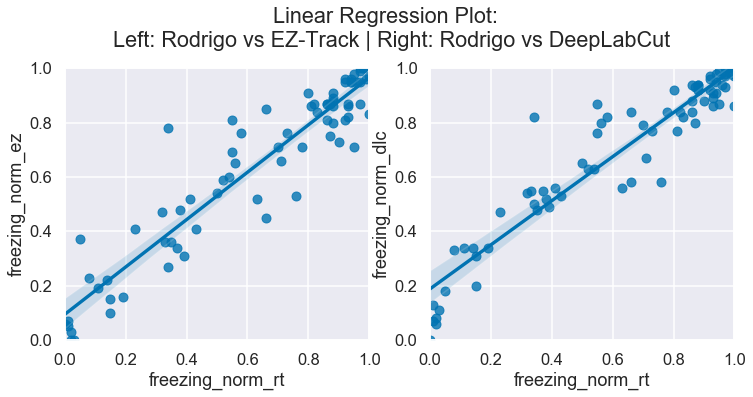

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(
    x='freezing_norm_rt',
    y='freezing_norm_ez',
    data=summary_stats_main,
    ax=axes[0]
)

sns.regplot(
    x='freezing_norm_rt',
    y='freezing_norm_dlc',
    data=summary_stats_main,
    ax=axes[1]
)
for n in range(2):
    axes[n].set(ylim=(0, 1), xlim=(0.,1))
fig.suptitle('Linear Regression Plot: \n Left: Rodrigo vs EZ-Track | Right: Rodrigo vs DeepLabCut', y=1.05)


Text(0.5, 1.05, 'Residual Plot for Linear Regression Fit: \n Left: Rodrigo vs EZ-Track | Right: Rodrigo vs DeepLabCut')

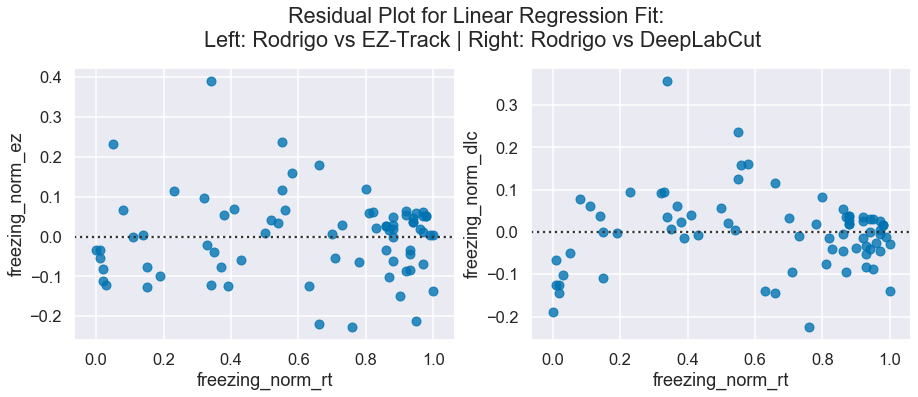

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.residplot(
    x='freezing_norm_rt',
    y='freezing_norm_ez',
    data=summary_stats_main,
    ax=axes[0]
)

sns.residplot(
    x='freezing_norm_rt',
    y='freezing_norm_dlc',
    data=summary_stats_main,
    ax=axes[1]
)

fig.suptitle('Residual Plot for Linear Regression Fit: \n Left: Rodrigo vs EZ-Track | Right: Rodrigo vs DeepLabCut', y=1.05)


### 3.2) Pearson's Correlation

In [81]:
r, p_value = stats.pearsonr(summary_stats_main['freezing_norm_dlc'],
               summary_stats_main['freezing_norm_rt'],)

print('Correlation coefficient between Deeplabcut vs Rodrigo')
print(f"Pearson's correlation coefficient is {round(r, 2)} with an associated p value of {p_value}")

Correlation coefficient between Deeplabcut vs Rodrigo
Pearson's correlation coefficient is 0.95 with an associated p value of 1.0421831979321213e-37


In [82]:
r, p_value = stats.pearsonr(summary_stats_main['freezing_norm_dlc'],
               summary_stats_main['freezing_norm_ez'],)

print('Correlation coefficient between Deeplabcut vs EzTrack (from Cai Lab)')
print(f"Pearson's correlation coefficient is {round(r, 2)} with an associated p value of {p_value}")

Correlation coefficient between Deeplabcut vs EzTrack (from Cai Lab)
Pearson's correlation coefficient is 0.97 with an associated p value of 5.804168208342703e-49


### 3.3) Linear Regressions

In [83]:
from sklearn.linear_model import LinearRegression

In [84]:
# Data to use in the regressions
freezing_rt = summary_stats_main[['freezing_norm_rt']]
freezing_dlc = summary_stats_main['freezing_norm_dlc']
freezing_ez = summary_stats_main[['freezing_norm_ez']]

#### 3.3.1) Rodrigo vs Deeplabcut

In [85]:
lm = LinearRegression()
lm.fit(freezing_rt, freezing_dlc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [86]:
print('Rodrigo vs Deeplabcut')
print(f'f(x) = {lm.coef_}x + {lm.intercept_}')
print(f'Coefficient of Determination : {round(lm.score(freezing_rt, freezing_dlc), 2)}')

Rodrigo vs Deeplabcut
f(x) = [0.81066082]x + 0.18827461557950276
Coefficient of Determination : 0.9


#### 3.3.1) Rodrigo vs EZtrack

In [87]:
lm = LinearRegression()
lm.fit(freezing_rt, freezing_ez)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [88]:
print('Rodrigo vs EZ Track')
print(f'f(x) = {(lm.coef_)}x + {lm.intercept_}')
print(f'Coefficient of Determination : {round(lm.score(freezing_rt, freezing_ez), 2)}')

Rodrigo vs EZ Track
f(x) = [[0.87109159]]x + [0.0946274]
Coefficient of Determination : 0.89


# 4) Descriptive Statistics

In [89]:
# Transform data into the long (ie "tidy" format)
summary_stats_main_long = summary_stats_main.melt(
    id_vars=['animal_id', 'cs_id', 'cs_epoch'],
    value_vars=['freezing_norm_dlc', 'freezing_norm_ez', 'freezing_norm_rt'],
    var_name='scorer',
    value_name='freezing_norm',
)

# Replace the name of scorers with shorter versions
summary_stats_main_long = summary_stats_main_long.replace(
    'freezing_norm_dlc', 'dlc').replace('freezing_norm_ez', 'ez').replace('freezing_norm_rt', 'rt')

summary_stats_main_long.head()

,animal_id,cs_id,cs_epoch,scorer,freezing_norm
0,286586,cs_01,peri_cs,dlc,0.80
1,286586,cs_02,peri_cs,dlc,0.65
2,286586,cs_03,peri_cs,dlc,0.34
3,286586,cs_04,peri_cs,dlc,0.08
4,286586,cs_05,peri_cs,dlc,0.34


In [90]:
summary_stats_main_long.head()

,animal_id,cs_id,cs_epoch,scorer,freezing_norm
0,286586,cs_01,peri_cs,dlc,0.80
1,286586,cs_02,peri_cs,dlc,0.65
2,286586,cs_03,peri_cs,dlc,0.34
3,286586,cs_04,peri_cs,dlc,0.08
4,286586,cs_05,peri_cs,dlc,0.34


### 4.2 Distributions of freezing accross scorers

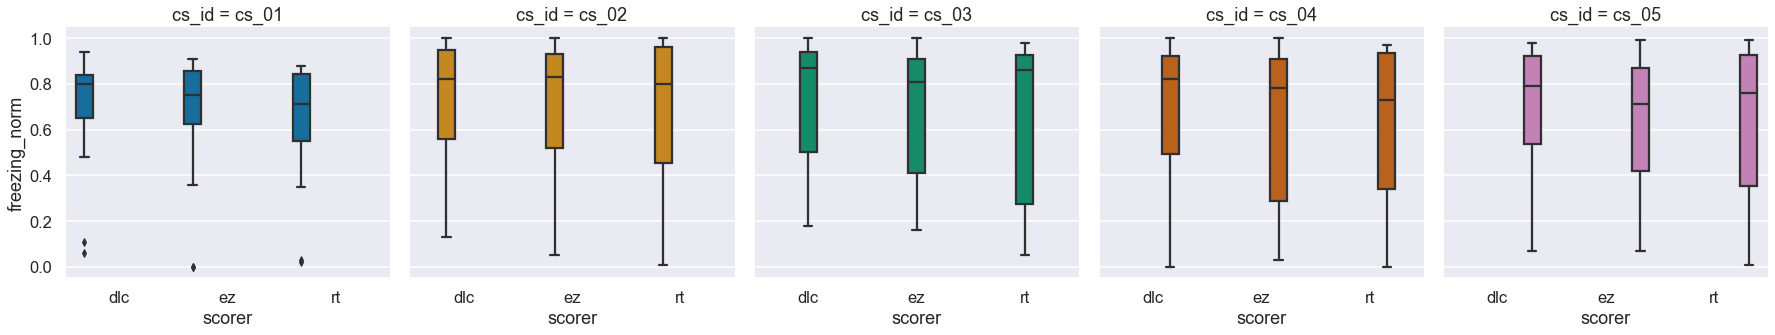

In [91]:
sns.catplot(
    x='scorer',
    y='freezing_norm',
    data=summary_stats_main_long,
    hue='cs_id',
    col='cs_id',
    kind='box'
)

### 4.3) What about the general distribution?

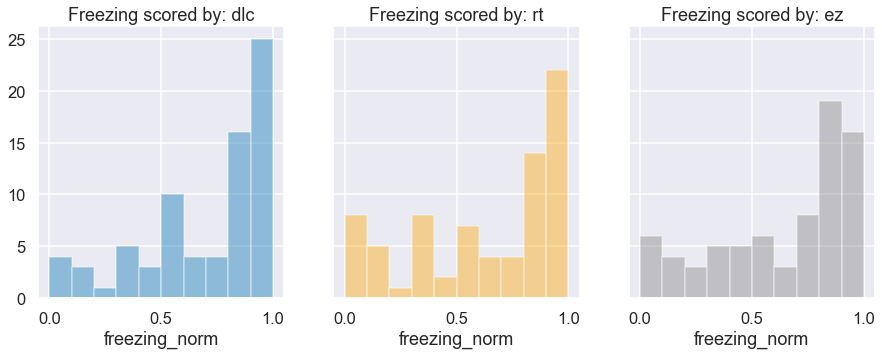

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.distplot(
    summary_stats_main_long[summary_stats_main_long['scorer']=='dlc'].freezing_norm,
    ax=axes[0], 
    bins= np.linspace(0, 1, 11),
    kde=False
)
sns.distplot(
    summary_stats_main_long[summary_stats_main_long['scorer']=='rt'].freezing_norm,
    ax=axes[1],
    bins= np.linspace(0, 1, 11),
    color='orange',
    kde=False
)
sns.distplot(
    summary_stats_main_long[summary_stats_main_long['scorer']=='ez'].freezing_norm,
    ax=axes[2],
    bins= np.linspace(0, 1, 11),
    color='grey',
    kde=False
)
for index, scorer in enumerate(['dlc', 'rt', 'ez']):
    axes[index].set(title=f'Freezing scored by: {scorer}')

### 4.4) Magnitude of freezing accress scorers, accross cs

(0, 1)

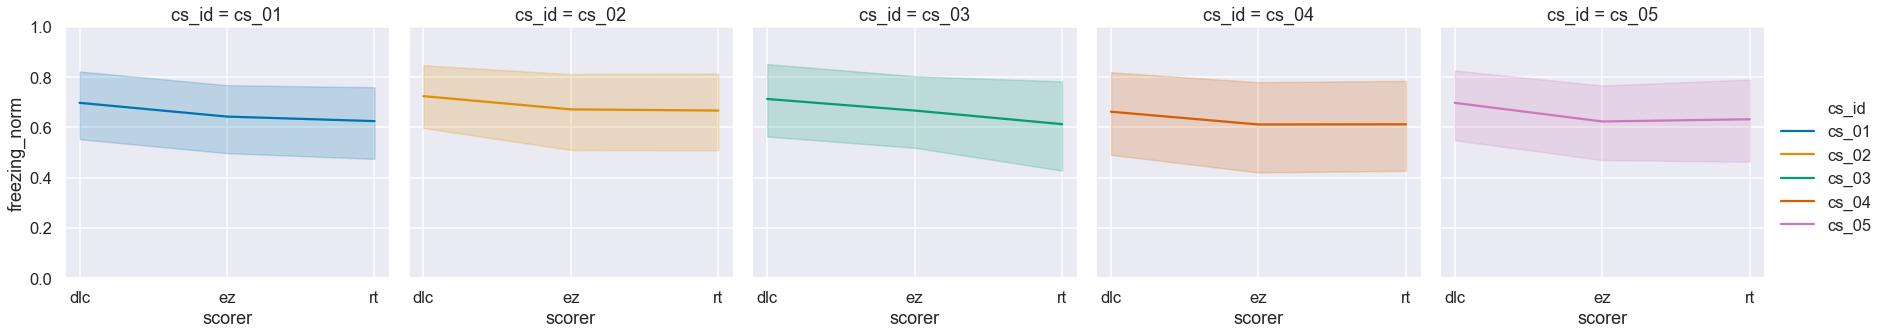

In [93]:
sns.relplot(
    x='scorer',
    y='freezing_norm',
    data=summary_stats_main_long,
    hue='cs_id',
    col='cs_id',
    kind='line',
)
plt.ylim(0, 1)

(0, 1)

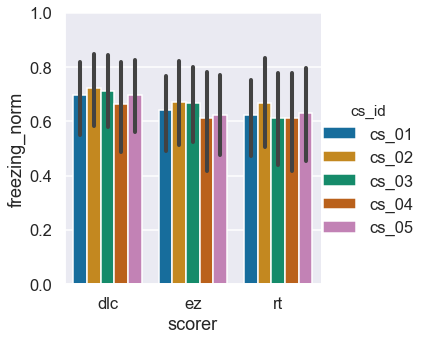

In [94]:
sns.catplot(
    x='scorer',
    y='freezing_norm',
    data=summary_stats_main_long,
    hue='cs_id',
    estimator=np.mean,
    kind='bar',
)
plt.ylim(0, 1)

### 4.5) Overall freezing

In [95]:
freezing = summary_stats_main_long.pivot_table(
    values=['freezing_norm'],
    index=['animal_id'],
    columns=['cs_id', 'scorer'],
)

freezing = freezing.groupby(axis=1, level=2).mean()
freezing.head()

scorer,dlc,ez,rt
animal_id,,,
286586,0.442,0.320,0.282
286587,0.660,0.600,0.454
286588,0.898,0.898,0.880
286589,0.352,0.234,0.206
286590,0.088,0.110,0.018


[(0, 1),
 Text(0, 0.5, 'freezing_norm'),
 Text(0.5, 0, 'scorer'),
 Text(0.5, 1.0, 'freezing normalized')]

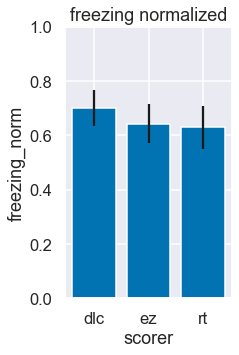

In [96]:
fig, ax = plt.subplots(figsize=(3, 5))
ax.bar(
    x=freezing.columns,
    height=freezing.mean(), 
    yerr=freezing.sem()
)

ax.set(ylim=(0, 1), title='freezing normalized', ylabel='freezing_norm', xlabel='scorer')

### 4.6) Are means significantly different?

In [97]:
freezing.reset_index(inplace=True)

In [98]:
# Preparing the data
freezing_long = freezing.melt(
    id_vars='animal_id',
    value_vars=['dlc', 'ez', 'rt'],
    var_name='scorer',
    value_name='freezing_norm'
)

In [99]:
pg.kruskal(
    freezing_long,
    dv='freezing_norm', 
    between='scorer',
    detailed=True
)

,Source,ddof1,H,p-unc
Kruskal,scorer,2,0.702941,0.703653


In [100]:
stats.kruskal(freezing.rt, freezing.dlc, freezing.ez)

KruskalResult(statistic=0.7029408534844409, pvalue=0.7036526589557721)